# Aggregation and Grouping

This notebook was adapted from [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake VanderPlas.

-----

An essential piece of analysis of large data is efficient summarization: computing aggregations like ``sum()``, ``mean()``, ``median()``, ``min()``, and ``max()``, in which a single number gives insight into the nature of a potentially large dataset.
In this section, we'll explore aggregations in Pandas, from simple operations akin to what we've seen on NumPy arrays, to more sophisticated operations based on the concept of a ``groupby``.

In [ ]:
import numpy as np
import pandas as pd

For convenience, we'll use ``display``, a way of 'printing' multiple objects in the HTML format

In [ ]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

## Simple Aggregation in Pandas

As with a one-dimensional NumPy array, for a Pandas ``Series`` the aggregates return a single value:

In [ ]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

In [ ]:
ser.sum()

In [ ]:
ser.mean()

For a ``DataFrame``, by default the aggregates return results within each column:

In [ ]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

In [ ]:
df.mean()

By specifying the ``axis`` argument, you can instead aggregate within each row:

In [ ]:
df.mean(axis='columns')

## Planets Data

The [Seaborn package](http://seaborn.pydata.org/) contains a number of interesting datasets (see [Visualization With Seaborn](https://jakevdp.github.io/PythonDataScienceHandbook/04.00-introduction-to-matplotlib.html))

In [ ]:
import seaborn as sns
print(sns.get_dataset_names())

Here we will use the Planets dataset. It gives information on planets that astronomers have discovered around other stars (known as *extrasolar planets* or *exoplanets* for short). It can be downloaded with a simple Seaborn command:

In [ ]:
planets = sns.load_dataset('planets')
planets.shape

In [ ]:
planets.sample(5)

This has some details on the 1,000+ extrasolar planets discovered up to 2014.

There is a convenience method ``describe()`` that computes several common aggregates for each column and returns the result.
Let's use this on the Planets data, for now dropping rows with missing values:

In [ ]:
planets.dropna().describe()

This can be a useful way to begin understanding the overall properties of a dataset.
For example, we see in the ``year`` column that although exoplanets were discovered as far back as 1989, half of all known expolanets were not discovered until 2010 or after.
This is largely thanks to the *Kepler* mission, which is a space-based telescope specifically designed for finding eclipsing planets around other stars.

The following table summarizes some other built-in Pandas aggregations:

| Aggregation              | Description                     |
|--------------------------|---------------------------------|
| ``count()``              | Total number of items           |
| ``first()``, ``last()``  | First and last item             |
| ``mean()``, ``median()`` | Mean and median                 |
| ``min()``, ``max()``     | Minimum and maximum             |
| ``std()``, ``var()``     | Standard deviation and variance |
| ``mad()``                | Mean absolute deviation         |
| ``prod()``               | Product of all items            |
| ``sum()``                | Sum of all items                |

These are all methods of ``DataFrame`` and ``Series`` objects.

To go deeper into the data, however, simple aggregates are often not enough.
The next level of data summarization is the ``groupby`` operation, which allows you to quickly and efficiently compute aggregates on subsets of data.

## GroupBy: Split, Apply, Combine

Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called ``groupby`` operation.
The name "group by" comes from a command in the SQL database language, but it is perhaps more illuminative to think of it in the terms first coined by Hadley Wickham of Rstats fame: *split, apply, combine*.

In [ ]:
planets.sample(5)

In [ ]:
planets.groupby('method').median()

### Split, apply, combine

A canonical example of this split-apply-combine operation, where the "apply" is a summation aggregation, is illustrated in this figure:

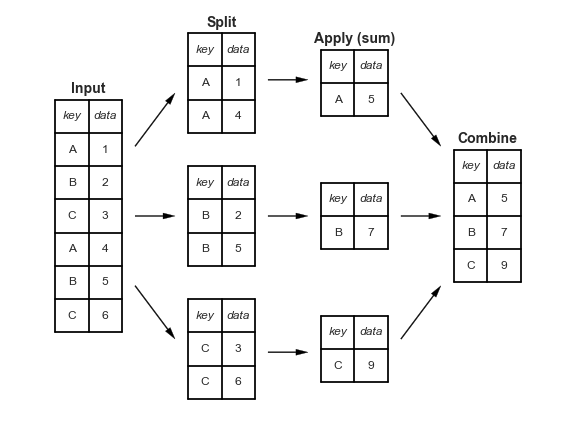

This makes clear what the ``groupby`` accomplishes:

- The *split* step involves breaking up and grouping a ``DataFrame`` depending on the value of the specified key.
- The *apply* step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The *combine* step merges the results of these operations into an output array.

While this could certainly be done manually using some combination of the masking, aggregation, and merging commands covered earlier, an important realization is that *the intermediate splits do not need to be explicitly instantiated*. Rather, the ``GroupBy`` can (often) do this in a single pass over the data, updating the sum, mean, count, min, or other aggregate for each group along the way.
The power of the ``GroupBy`` is that it abstracts away these steps: the user need not think about *how* the computation is done under the hood, but rather thinks about the *operation as a whole*.

As a concrete example, let's take a look at using Pandas for the computation shown in this diagram.
We'll start by creating the input ``DataFrame``:

In [ ]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)
                  })
df

The most basic split-apply-combine operation can be computed with the ``groupby()`` method of ``DataFrame``s, passing the name of the desired key column:

In [ ]:
df.groupby('key')

Notice that what is returned is not a set of ``DataFrame``s, but a ``DataFrameGroupBy`` object.
This object is where the magic is: you can think of it as a special view of the ``DataFrame``, which is poised to dig into the groups but does no actual computation until the aggregation is applied.
This "lazy evaluation" approach means that common aggregates can be implemented very efficiently in a way that is almost transparent to the user.

To produce a result, we can apply an aggregate to this ``DataFrameGroupBy`` object, which will perform the appropriate apply/combine steps to produce the desired result:

In [ ]:
df.groupby('key').sum()

The ``sum()`` method is just one possibility here; you can apply virtually any common Pandas or NumPy aggregation function, as well as virtually any valid ``DataFrame`` operation, as we will see in the following discussion.

### The GroupBy object

The ``GroupBy`` object is a very flexible abstraction.
In many ways, you can simply treat it as if it's a collection of ``DataFrame``s, and it does the difficult things under the hood. Let's see some examples using the Planets data.

Perhaps the most important operations made available by a ``GroupBy`` are *aggregate*, *filter*, *transform*, and *apply*.
Let's introduce some of the other functionality that can be used with the basic ``GroupBy`` operation.

#### Column indexing

The ``GroupBy`` object supports column indexing in the same way as the ``DataFrame``, and returns a modified ``GroupBy`` object.
For example:

In [ ]:
planets.sample(5)

In [ ]:
planets.groupby('method')

In [ ]:
planets.groupby('method').median()

In [ ]:
planets.groupby('method')['orbital_period']

Here we've selected a particular ``Series`` group from the original ``DataFrame`` group by reference to its column name.
As with the ``GroupBy`` object, no computation is done until we call some aggregate on the object:

In [ ]:
planets.groupby('method')['orbital_period'].median()

This gives an idea of the general scale of orbital periods (in days) that each method is sensitive to.

#### Iteration over groups

The ``GroupBy`` object supports direct iteration over the groups, returning each group as a ``Series`` or ``DataFrame``:

In [ ]:
for (method, group) in planets.groupby('method'):
    print(f"====> {method:30s} shape={group.shape}")
    #print(group)

This can be useful for doing certain things manually, though it is often much faster to use the built-in ``apply`` functionality, which we will discuss momentarily.

#### Dispatch methods

Through some Python class magic, any method not explicitly implemented by the ``GroupBy`` object will be passed through and called on the groups, whether they are ``DataFrame`` or ``Series`` objects.
For example, you can use the ``describe()`` method of ``DataFrame``s to perform a set of aggregations that describe each group in the data:

In [ ]:
planets.groupby('method')['year'].describe()

Looking at this table helps us to better understand the data: for example, the vast majority of planets have been discovered by the Radial Velocity and Transit methods, though the latter only became common (due to new, more accurate telescopes) in the last decade.
The newest methods seem to be Transit Timing Variation and Orbital Brightness Modulation, which were not used to discover a new planet until 2011.

This is just one example of the utility of dispatch methods.
Notice that they are applied *to each individual group*, and the results are then combined within ``GroupBy`` and returned.
Again, any valid ``DataFrame``/``Series`` method can be used on the corresponding ``GroupBy`` object, which allows for some very flexible and powerful operations!

### Aggregate, filter, transform, apply

The preceding discussion focused on aggregation for the combine operation, but there are more options available.
In particular, ``GroupBy`` objects have ``aggregate()``, ``filter()``, ``transform()``, and ``apply()`` methods that efficiently implement a variety of useful operations before combining the grouped data.

For the purpose of the following subsections, we'll use this ``DataFrame``:

In [ ]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

#### Aggregation

We're now familiar with ``GroupBy`` aggregations with ``sum()``, ``median()``, and the like, but the ``aggregate()`` method allows for even more flexibility.
It can take a string, a function, or a list thereof, and compute all the aggregates at once.
Here is a quick example combining all these:

In [ ]:
df.groupby('key').min()

In [ ]:
df.groupby('key').aggregate([min, np.median, max])

In [ ]:
df.groupby('key').aggregate(['min', np.median, 'max'])

Another useful pattern is to pass a dictionary mapping column names to operations to be applied on that column:

In [ ]:
df.groupby('key').aggregate({'data1': 'min', 'data2': 'max'})

#### Filtering

A filtering operation allows you to drop data based on the group properties.
For example, we might want to keep all groups in which the standard deviation is larger than some critical value:

In [ ]:
df

In [ ]:
df.groupby('key').std()

In [ ]:
# suppose you want to only include data for groups that obey to a certain criteria 
def filter_func(x):
    ''' x is a DataFrame of group values '''
    return x['data2'].std() > 4

df.groupby('key').filter(filter_func)

Or, we can use the magic function `display`to show all the 3 results

In [ ]:
def filter_func(x):
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")

The filter function should return a Boolean value specifying whether the group passes the filtering. Here because group A does not have a standard deviation greater than 4, it is dropped from the result.

#### Transformation

While aggregation must return a reduced version of the data, transformation can return some transformed version of the full data to recombine.
For such a transformation, the output is the same shape as the input.
A common example is to center the data by subtracting the group-wise mean:

In [ ]:
def sub_group_mean(x):
    ''' x is a DataFrame of group values '''
    return x - x.mean()

df.groupby('key').transform(sub_group_mean)

#### The apply() method

The ``apply()`` method lets you apply an arbitrary function to the group results.
The function should take a ``DataFrame``, and return either a Pandas object (e.g., ``DataFrame``, ``Series``) or a scalar; the combine operation will be tailored to the type of output returned.

For example, here is an ``apply()`` that normalizes the first column by the sum of the second:

In [ ]:
df

In [ ]:
def norm_by_data2(x):
    ''' x is a DataFrame of group values '''
    x['data1'] /= x['data2'].sum()
    return x

display('df', "df.groupby('key').apply(norm_by_data2)")

``apply()`` within a ``GroupBy`` is quite flexible: the only criterion is that the function takes a ``DataFrame`` and returns a Pandas object or scalar; what you do in the middle is up to you!

### (Extra) Specifying the split key

In the simple examples presented before, we split the ``DataFrame`` on a single column name.
This is just one of many options by which the groups can be defined, and we'll go through some other options for group specification here.

#### A list, array, series, or index providing the grouping keys

The key can be any series or list with a length matching that of the ``DataFrame``. For example:

In [ ]:
L = [0, 1, 0, 1, 2, 0]
L = ["Mike", "Ana", "Mike", "Ana", "Peter", "Mike"]
display('df', 'df.groupby(L).sum()')

Of course, this means there's another, more verbose way of accomplishing the ``df.groupby('key')`` from before:

In [ ]:
display('df', "df.groupby(df['key']).sum()")

#### A dictionary or series mapping index to group

Another method is to provide a dictionary that maps index values to the group keys:

In [ ]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

#### Any Python function

Similar to mapping, you can pass any Python function that will input the index value and output the group:

In [ ]:
display('df2', 'df2.groupby(str.lower).mean()')

#### A list of valid keys

Further, any of the preceding key choices can be combined to group on a multi-index:

In [ ]:
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
df2.groupby([str.lower, mapping]).mean()

### Grouping example

As an example of this, in a couple lines of Python code we can put all these together and count discovered planets by method and by decade:

In [ ]:
planets

In [ ]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'
decade

In [ ]:
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

This shows the power of combining many of the operations we've discussed up to this point when looking at realistic datasets.
We immediately gain a coarse understanding of when and how planets have been discovered over the past several decades!

Here I would suggest digging into these few lines of code, and evaluating the individual steps to make sure you understand exactly what they are doing to the result.
It's certainly a somewhat complicated example, but understanding these pieces will give you the means to similarly explore your own data.